<a href="https://colab.research.google.com/github/CCMunozB/Patrones/blob/main/11-ViT_plus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visual Transformers

In [ ]:
!pip install -q transformers==4.28.0
!pip install -q evaluate
!pip install -q git+https://github.com/huggingface/accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 11.5 MB/s eta 0:00:00
  Installing build dependencies ...

# ViT Clasificación

In [ ]:
from transformers import AutoImageProcessor, ViTForImageClassification
import torch
from datasets import load_dataset

dataset = load_dataset("huggingface/cats-image")
image = dataset["test"]["image"][0]

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", output_attentions=True)

inputs = image_processor(image, return_tensors="pt")

with torch.no_grad():
    output = model(**inputs)
    logits = output.logits


  0%|          | 0/1 [00:00<?, ?it/s]

Egyptian cat


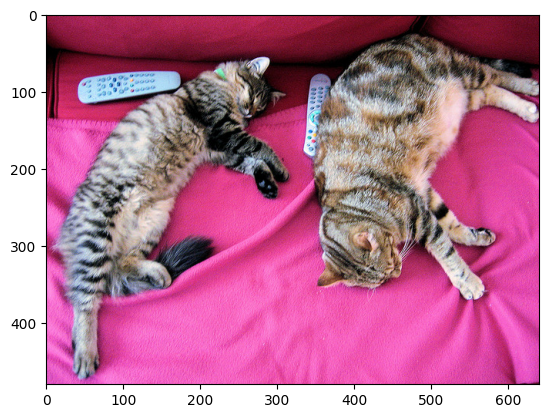

In [ ]:
# model predicts one of the 1000 ImageNet classes
predicted_label = int(tf.math.argmax(logits, axis=-1))
print(model.config.id2label[predicted_label])
plt.imshow(image)

In [ ]:
len(output.attentions)

12

In [ ]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [ ]:
attention_maps = output.attentions

In [ ]:
attention_maps[4].shape

torch.Size([1, 12, 197, 197])

## Actividad 1

Visualice el mapa de atención de las últimas 2 capas de autoatención y proyectelo sobre la imágen original.

Hint: Los mapas de atención multicabezales se promedian en uno solo

Hint2: Rescale el mapa de atención

In [ ]:
#Prográmame


# Swin Segmentation

In [ ]:
from transformers import AutoImageProcessor, UperNetForSemanticSegmentation
from PIL import Image
from huggingface_hub import hf_hub_download

image_processor = AutoImageProcessor.from_pretrained("openmmlab/upernet-swin-large")
model = UperNetForSemanticSegmentation.from_pretrained("openmmlab/upernet-swin-large", output_attentions=True)

filepath = hf_hub_download(
    repo_id="hf-internal-testing/fixtures_ade20k", filename="ADE_val_00000001.jpg", repo_type="dataset"
)
image = Image.open(filepath).convert("RGB")

inputs = image_processor(images=image, return_tensors="pt")

outputs = model(**inputs)

logits = outputs.logits  # shape (batch_size, num_labels, height, width)

In [ ]:
import torch

upsampled_logits = torch.nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]

In [ ]:
def ade_palette():
  """Creates a label colormap used in ADE20K segmentation benchmark.

  Returns:
    A colormap for visualizing segmentation results.
  """
  return np.asarray([
      [0, 0, 0],
      [120, 120, 120],
      [180, 120, 120],
      [6, 230, 230],
      [80, 50, 50],
      [4, 200, 3],
      [120, 120, 80],
      [140, 140, 140],
      [204, 5, 255],
      [230, 230, 230],
      [4, 250, 7],
      [224, 5, 255],
      [235, 255, 7],
      [150, 5, 61],
      [120, 120, 70],
      [8, 255, 51],
      [255, 6, 82],
      [143, 255, 140],
      [204, 255, 4],
      [255, 51, 7],
      [204, 70, 3],
      [0, 102, 200],
      [61, 230, 250],
      [255, 6, 51],
      [11, 102, 255],
      [255, 7, 71],
      [255, 9, 224],
      [9, 7, 230],
      [220, 220, 220],
      [255, 9, 92],
      [112, 9, 255],
      [8, 255, 214],
      [7, 255, 224],
      [255, 184, 6],
      [10, 255, 71],
      [255, 41, 10],
      [7, 255, 255],
      [224, 255, 8],
      [102, 8, 255],
      [255, 61, 6],
      [255, 194, 7],
      [255, 122, 8],
      [0, 255, 20],
      [255, 8, 41],
      [255, 5, 153],
      [6, 51, 255],
      [235, 12, 255],
      [160, 150, 20],
      [0, 163, 255],
      [140, 140, 140],
      [250, 10, 15],
      [20, 255, 0],
      [31, 255, 0],
      [255, 31, 0],
      [255, 224, 0],
      [153, 255, 0],
      [0, 0, 255],
      [255, 71, 0],
      [0, 235, 255],
      [0, 173, 255],
      [31, 0, 255],
      [11, 200, 200],
      [255, 82, 0],
      [0, 255, 245],
      [0, 61, 255],
      [0, 255, 112],
      [0, 255, 133],
      [255, 0, 0],
      [255, 163, 0],
      [255, 102, 0],
      [194, 255, 0],
      [0, 143, 255],
      [51, 255, 0],
      [0, 82, 255],
      [0, 255, 41],
      [0, 255, 173],
      [10, 0, 255],
      [173, 255, 0],
      [0, 255, 153],
      [255, 92, 0],
      [255, 0, 255],
      [255, 0, 245],
      [255, 0, 102],
      [255, 173, 0],
      [255, 0, 20],
      [255, 184, 184],
      [0, 31, 255],
      [0, 255, 61],
      [0, 71, 255],
      [255, 0, 204],
      [0, 255, 194],
      [0, 255, 82],
      [0, 10, 255],
      [0, 112, 255],
      [51, 0, 255],
      [0, 194, 255],
      [0, 122, 255],
      [0, 255, 163],
      [255, 153, 0],
      [0, 255, 10],
      [255, 112, 0],
      [143, 255, 0],
      [82, 0, 255],
      [163, 255, 0],
      [255, 235, 0],
      [8, 184, 170],
      [133, 0, 255],
      [0, 255, 92],
      [184, 0, 255],
      [255, 0, 31],
      [0, 184, 255],
      [0, 214, 255],
      [255, 0, 112],
      [92, 255, 0],
      [0, 224, 255],
      [112, 224, 255],
      [70, 184, 160],
      [163, 0, 255],
      [153, 0, 255],
      [71, 255, 0],
      [255, 0, 163],
      [255, 204, 0],
      [255, 0, 143],
      [0, 255, 235],
      [133, 255, 0],
      [255, 0, 235],
      [245, 0, 255],
      [255, 0, 122],
      [255, 245, 0],
      [10, 190, 212],
      [214, 255, 0],
      [0, 204, 255],
      [20, 0, 255],
      [255, 255, 0],
      [0, 153, 255],
      [0, 41, 255],
      [0, 255, 204],
      [41, 0, 255],
      [41, 255, 0],
      [173, 0, 255],
      [0, 245, 255],
      [71, 0, 255],
      [122, 0, 255],
      [0, 255, 184],
      [0, 92, 255],
      [184, 255, 0],
      [0, 133, 255],
      [255, 214, 0],
      [25, 194, 194],
      [102, 255, 0],
      [92, 0, 255],
  ])

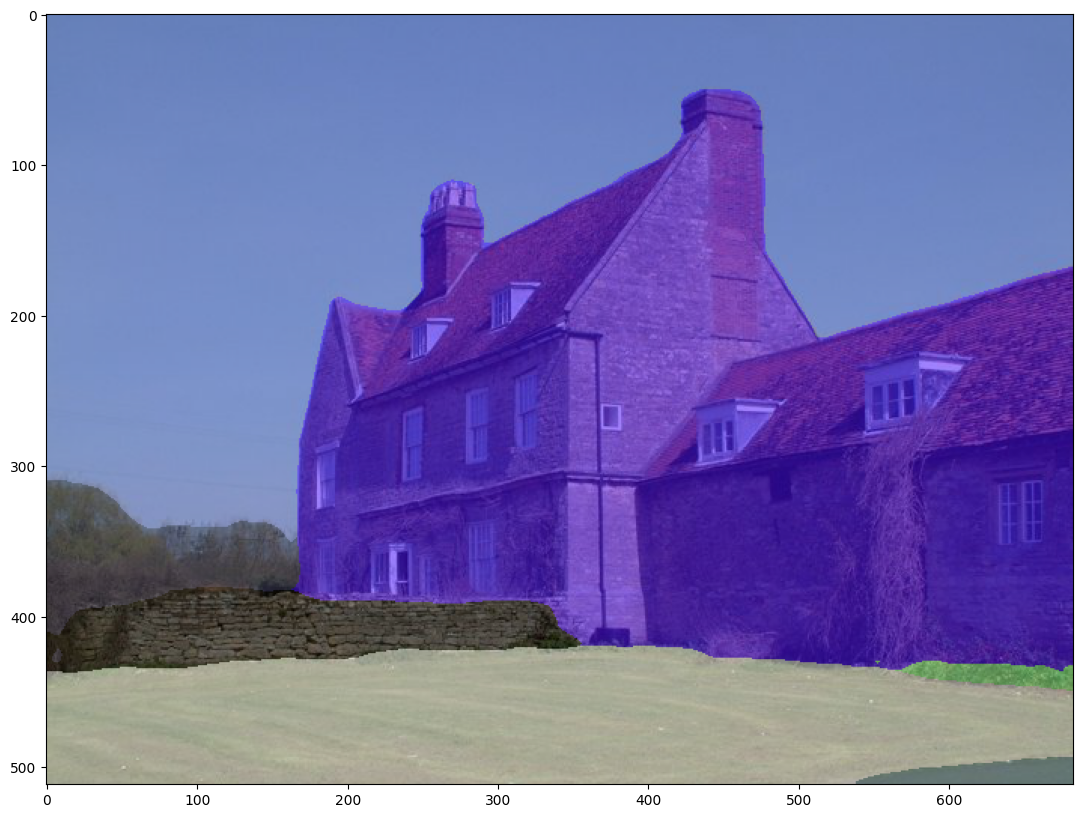

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

color_seg = np.zeros((pred_seg.shape[0], pred_seg.shape[1], 3), dtype=np.uint8)
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[pred_seg == label, :] = color
color_seg = color_seg[..., ::-1]  # convert to BGR

img = np.array(image) * 0.5 + color_seg * 0.5  # plot the image with the segmentation map
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

In [ ]:
model

UperNetForSemanticSegmentation(
  (backbone): SwinBackbone(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0-1): 2 x SwinLayer(
              (layernorm_before): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=192, out_features=192, bias=True)
                  (key): Linear(in_features=192, out_features=192, bias=True)
                  (value): Linear(in_features=192, out_features=192, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output)

In [ ]:
print(outputs.attentions[0].shape)
print(outputs.attentions[1].shape)
print(outputs.attentions[2].shape)
print(outputs.attentions[3].shape)

torch.Size([121, 6, 144, 144])
torch.Size([36, 12, 144, 144])
torch.Size([9, 24, 144, 144])
torch.Size([4, 48, 144, 144])


In [ ]:
# Get batch size and number of heads
batch_size, num_heads, seq_length, _ = outputs.attentions[3].shape


# Reshape and combine attention maps for each batch
reshaped_attention_maps = outputs.attentions[3].squeeze().detach().cpu().numpy()
combined_attention_maps = np.mean(reshaped_attention_maps, axis=0)
combined_attention_maps = np.mean(combined_attention_maps, axis=0)

In [ ]:
res = combined_attention_maps.reshape([12*12, 12, 12])
res = np.mean(res, axis=0)

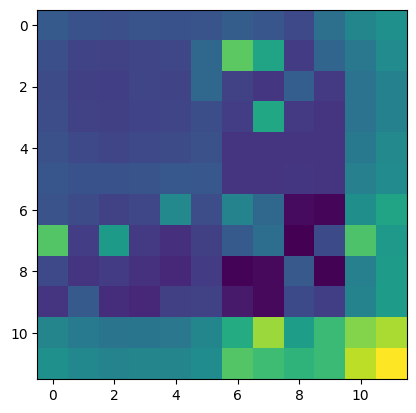

In [ ]:
plt.imshow(res)

In [ ]:
import cv2
res = cv2.resize(res, dsize=(683, 512), interpolation=cv2.INTER_CUBIC)

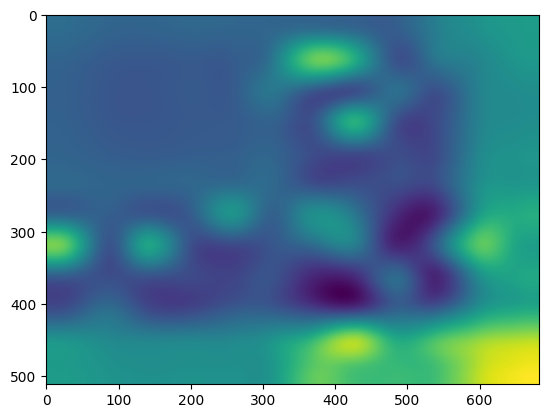

In [ ]:
plt.imshow(res)

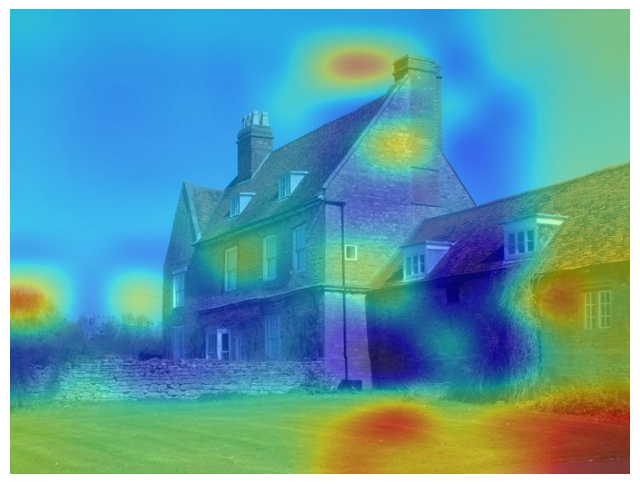

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image)
ax.imshow(res, cmap="jet", alpha=0.5, interpolation="bilinear")

plt.axis("off")
plt.show()